# Research with Professor Margutti

## Understanding the Photometry of the Kilonova from GW170817

In [1620]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import numpy as np
import astropy as astro
import random
import itertools
import mosfit
import pandas
import sncosmo
import pyqt_fit
import os
import scipy
import matplotlib.colors as colors
import matplotlib.cm as cmx
import astropy.units as u
import pyqt_fit.nonparam_regression as smooth
import statsmodels.api as sm
from matplotlib import rc
from sklearn.svm import SVR
from astropy.table import Table, Column, vstack
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from astropy.time import Time
from scipy.constants import h,k,c,Stefan_Boltzmann
from scipy.interpolate import interp1d, Rbf, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, MaxNLocator, AutoLocator
from operator import itemgetter, attrgetter
from pyqt_fit import npr_methods
matplotlib.style.use('classic')
plt.rcParams["figure.figsize"] = (11,8)
%matplotlib inline

In [1310]:
# GW Sources
GW170817 = ascii.read("GW170817.txt")
Villar = ascii.read("Villar Data.csv")

#Constants

# - plotting
tickfontsize = 20
axeslabelsize = 25
titlesize = 38
titley = 1.02
marker=1.2
legend = 17
points = 1
scale = 0.85
majorticklength = 7
minorticklength = 4
majortickwidth = 1
minortickwidth = 1

# - trigger
trigger = Time('2017-08-17 12:41:04')
trigger = trigger.mjd

In [1311]:
#
# Bandpasses
#
        

# Filter
    
def bandpasses(folder):
    bandpasses = list_bandpass(folder)
    bandpasses1 = map_angstrom(bandpasses)
    bandpasses2 = map_transmission(bandpasses1)
    bandpasses3 = map_order(bandpasses2)
    bandpasses_new = clean_bandpasses(bandpasses3)
    return bandpasses_new

def list_bandpass(folder):
    band_passes = {}
    
    if folder == 'LSST Filters':
        x = 0
    else:
        x = 1
    for file in os.listdir(folder)[x:]:
        key = str(file)
        value = ascii.read(folder+"/"+file)
        band_passes[key[:-4]] = value
    
    return band_passes


def map_angstrom(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        
        if table.colnames[0] == 'wavelength(A)':
            table['wavelength(A)'] = table['wavelength(A)']
            table.rename_column('wavelength(A)', 'wavelength')
            bandpasses_new[key] = table
            
        elif table.colnames[0] == 'wavelength(nm)':
            table['wavelength(nm)'] = 10*table['wavelength(nm)']
            table.rename_column('wavelength(nm)', 'wavelength')
            bandpasses_new[key] = table
            
        elif table.colnames[0] == 'wavelength(mu)':
            table['wavelength(mu)'] = 10000*table['wavelength(mu)']
            table.rename_column('wavelength(mu)', 'wavelength')
            bandpasses_new[key] = table
            
        else:
            table.rename_column(table.colnames[0], 'wavelength')
            bandpasses_new[key] = table
    
    return bandpasses_new


def map_transmission(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        
        if table.colnames[1] == 'transmission':
            bandpasses_new[key] = table
        
        elif table.colnames[1] == 'transmission(%)':
            table['transmission(%)'] = 0.01*table['transmission(%)']
            table.rename_column('transmission(%)', 'transmission')
            bandpasses_new[key] = table
    
    return bandpasses_new


def map_order(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        x = []
        y_wave = []
        y_trans = []
        for i in range(len(table)):
            x.append([table['wavelength'][i], table['transmission'][i]])
            
        y = sorted(x, key=itemgetter(0))
        
        for i in range(len(y)):
            y_wave.append(y[i][0])
            y_trans.append(y[i][1])
            
        table_new = Table((y_wave,y_trans), names=('wavelength', 'transmission'))
        bandpasses_new[key] = table_new
    return bandpasses_new

def clean_bandpasses(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        bandpasses_new[key] = clean_up(table)
    return bandpasses_new
        

def clean_up(table):
    df = table.to_pandas()
    df = df.groupby('wavelength', as_index=False)['transmission'].mean()
    new_table = Table.from_pandas(df)
    return new_table

            
# Plot        

def plot_bandpasses(bandpasses):
    interps = interp_bandpasses(bandpasses)
    print('This bandpass dictionary has the following bandpasses:')
    filter_list = list(bandpasses.keys())
    print()
    print(filter_list)
    print()
    plot_bandchoices(bandpasses, filter_list, interps)
    return

def plot_bandchoices(bandpasses, filter_list, interps):
    print('Choose bandpasses to plot (e.g. DECam g, SIRIUS Ks, UVOT M2) or plot all:')
    bandpass_choices = input()
    bandpass_choices = bandpass_choices.split(', ')
    if bandpass_choices[0] == 'all':
        for bandpass in filter_list:
            plot_bandpass(bandpasses, bandpass) 
    
    if all([bandpass in filter_list for bandpass in bandpass_choices]):
        for bandpass in bandpass_choices:
            plot_bandpass(bandpasses, bandpass)
            #plot_interpolations(bandpasses, bandpass, interps)
            
    else:
        print('Bandpasses not found. Please try again.')
        plot_bandchoices(bandpasses, filter_list, interps)
    return


def plot_bandpass(bandpasses, bandpass):
    majorLocatorx = MultipleLocator(500)
    majorFormatter = FormatStrFormatter('%d')
    minorLocatorx = MultipleLocator(100)
    majorLocatory = MultipleLocator(0.2)
    minorLocatory = MultipleLocator(0.04)
    table = bandpasses[bandpass]
    fig = plt.figure(figsize=(14,11))
    ax1 = plt.subplot(111)

    #data
    plt.plot(table['wavelength'], table['transmission'])

    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Wavelength (Angstroms)', fontsize=axeslabelsize)
    plt.ylabel('Transmission', fontsize=axeslabelsize)
    plt.ylim(0.0, 1.0)
    xticks, xticklabels = plt.xticks()
    # shift half a step to the left
    # x0 - (x1 - x0) / 2 = (3 * x0 - x1) / 2
    xmin = (3*xticks[0] - xticks[1])/2
    # shaft half a step to the right
    xmax = (3*xticks[-1] - xticks[-2])/2.
    plt.xlim(xmin, xmax)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_locator(majorLocatory)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_minor_locator(minorLocatory)

    #plt.title(bandpass, fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    return




#
# Interpolations
#


def interp_bandpasses(bandpasses):
    approx = 'cubic'
    interpolations = {}
    
    for key,table in bandpasses.items():
        interp = interp1d(table['wavelength'], table['transmission'], bounds_error=False, fill_value=0)
        interpolations[key] = interp
    return interpolations


def plot_interpolations(bandpasses, bandpass, interps):
    majorLocatorx = MultipleLocator(500)
    majorFormatter = FormatStrFormatter('%d')
    minorLocatorx = MultipleLocator(100)
    majorLocatory = MultipleLocator(0.2)
    minorLocatory = MultipleLocator(0.04)
    table = bandpasses[bandpass]
    fig = plt.figure(figsize=(11,8))
    ax1 = plt.subplot(111)
    new_wavelengths = wavelength_new(table)

    #data
    plt.plot(new_wavelengths, interps[bandpass](new_wavelengths))

    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Wavelength (Angstroms)', fontsize=axeslabelsize)
    plt.ylabel('Transmission', fontsize=axeslabelsize)
    plt.ylim(0.0, 1.0)
    xticks, xticklabels = plt.xticks()
    # shift half a step to the left
    # x0 - (x1 - x0) / 2 = (3 * x0 - x1) / 2
    xmin = (3*xticks[0] - xticks[1])/2
    # shaft half a step to the right
    xmax = (3*xticks[-1] - xticks[-2])/2.
    plt.xlim(xmin, xmax)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_locator(majorLocatory)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_minor_locator(minorLocatory)

    plt.title(bandpass+' Interpolation', fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    return
    

def wavelength_new(table):
    set_length=10000
    day_new = np.linspace(min(table['wavelength']),
                          max(table['wavelength']),set_length)
    return day_new

In [1312]:
band_passes = bandpasses("Telescope Filters")

In [1313]:
#plot_bandpasses(band_passes)

In [1314]:
#
# Lambda Effective (Average)
#

def lambda_effectives(bandpasses):
    interps = interp_bandpasses(bandpasses)
    bandpasses_new = {}
    for key, table in bandpasses.items():
        global interp
        interp = interps[key]
        bandpasses_new[key] = calc_lambda(table, interp)
    if 'MASTER R' and 'MASTER B' in list(bandpasses_new.keys()):
        bandpasses_new['MASTER W'] = 0.8*bandpasses_new['MASTER R']+0.2*bandpasses_new['MASTER B'] 
    return bandpasses_new


def calc_lambda(table, interp):
    lambda_eff = np.divide(quad(f, min(wavelength_new(table)), max(wavelength_new(table)))[0],
                           quad(interp, min(wavelength_new(table)), max(wavelength_new(table)))[0])
    return lambda_eff

def f(x):
    return x*interp(x)


# REFERENCE
def lambda_ref(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        bandpasses_new[key] = calc_ref(table)
    return bandpasses_new

def calc_ref(table):
    wavelength = table['wavelength']
    transmission = table['transmission']
    bandpass = sncosmo.Bandpass(wavelength, transmission)
    return bandpass.wave_eff


# COMPARISON

def compare_lambdas(bandpasses):
    dictionary = {}
    observed = lambda_effectives(bandpasses)
    expected = lambda_ref(bandpasses)
    for key, value in observed.items():
        for key1, value1 in expected.items():
            if key == key1:
                dictionary[key] = [value1, value, value1-value]        
    return Table([list(dictionary.keys()), list(np.array(list(dictionary.values()))[:, 0].flatten()),
                  list(np.array(list(dictionary.values()))[:, 1].flatten()), list(np.array(list(dictionary.values()))[:, 2].flatten())],
                 names=('Filter', 'Expected Wavelength', 'Observed Wavelength', 'Difference'))


def wavelength_new(table):
    set_length=10000
    day_new = np.linspace(min(table['wavelength']),
                          max(table['wavelength']),set_length)
    return day_new

In [1315]:
lambda_eff = lambda_effectives(band_passes)

In [1316]:
#
# Extinction Coefficient
#


f_lambda = ascii.read('f_lambda.txt')
R = 3.1
E_BV = 0.1053
E_err = 0.0012
A_V = R*E_BV
A_B = E_BV+A_V


def f_interp(data = f_lambda):
    approx = 'cubic'
    interp = interp1d(data['1/lambda'], data['f(lambda)'], kind=approx)
    return interp


#
# Plotting
#


def f_plot(data = f_lambda):
    majorLocatorx = MultipleLocator(2)
    majorFormatter = FormatStrFormatter('%d')
    minorLocatorx = MultipleLocator(0.5)
    majorLocatory = MultipleLocator(2)
    minorLocatory = MultipleLocator(0.4)
    fig = plt.figure(figsize=(11,8))
    ax1 = plt.subplot(111)
    lambda_inv = f_new(data)
    interp = f_interp(data)
    f_lambdas = np.divide(interp(lambda_inv)+R, 1+R)

    #data
    plt.plot(10000*lambda_inv, f_lambdas)

    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('1/$\\lambda$ Reciprocal Wavelength ($\\mu$m$^{-1}$)', fontsize=axeslabelsize)
    plt.ylabel('A$_\\lambda$/A$_B$', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    plt.ylim(0,np.ceil(max(f_lambdas)))
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_locator(majorLocatory)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax1.yaxis.set_minor_locator(minorLocatory)

    plt.title('Extinction Coefficients', fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    return

def f_new(data = f_lambda):
    set_length=10000
    day_new = np.linspace(min(data['1/lambda']),
                          max(data['1/lambda']),set_length)
    return day_new




#
# Extinction Magnitudes
#


def ext_mags(lambdas = lambda_eff, ext_co = f_lambda):
    mags = {}
    interp = f_interp(ext_co)
    for key, wavelength in lambdas.items():
        wave_inv = 1/wavelength
        A_lambda = np.divide(interp(wave_inv)+R, 1+R)*A_B
        mags[key] = A_lambda
    return mags
    

In [1317]:
#f_plot()

In [1318]:
extinctions = ext_mags()

In [1319]:
#
# Flux Conversions
#

def convert_to_flux(gwsource=Villar):
    gwsource_cor = corrected_mags(gwsource)
    f_lambdas = calc_f_lambdas(gwsource_cor, 'magnitudes')
    f_sigmas = calc_f_lambdas(gwsource_cor, 'sigmas')
    
    col1 = Column(f_lambdas, name='flux')
    col2 = Column(f_sigmas, name='e_flux')
            
    titles = gwsource.colnames
    titles.remove('magnitude')
    titles.remove('e_magnitude')
    
    table = Table([gwsource[title] for title in titles], names=(title for title in titles))
    table.add_column(col2, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    table.add_column(col1, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    
    return table


#Note: this functions is for comparison

def convert_to_flux_noncorrected(gwsource=Villar):
    gwsource_cor = gwsource
    f_lambdas = calc_f_lambdas(gwsource_cor, 'magnitudes')
    f_sigmas = calc_f_lambdas(gwsource_cor, 'sigmas')
    
    col1 = Column(f_lambdas, name='flux')
    col2 = Column(f_sigmas, name='e_flux')
            
    titles = gwsource.colnames
    titles.remove('magnitude')
    titles.remove('e_magnitude')
    
    table = Table([gwsource[title] for title in titles], names=(title for title in titles))
    table.add_column(col2, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    table.add_column(col1, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    
    return table


def calc_f_lambdas(gwsource, choice):
    converted_data = []
    lambdas = lambda_eff
    c = astro.constants.c.to('Angstrom/s').value
    
    instruments = gwsource['instrument']
    bands = gwsource['band']
    
    if choice == 'magnitudes':
        data = calc_f_nus(gwsource)
    
    if choice == 'sigmas':
        data = calc_f_nus_sigmas(gwsource)
    
    
    for i in range(len(gwsource)):
        if instruments[i]+' '+bands[i] in list(lambdas.keys()):
            lam_eff = lambdas[instruments[i]+' '+bands[i]]
            flux = (c/(lam_eff**2))*data[i]
            converted_data.append(flux)
        
        elif instruments[i]+'_'+bands[i] in list(lambdas.keys()):
            lam_eff = lambdas[instruments[i]+'_'+bands[i]]
            flux = (c/(lam_eff**2))*data[i]
            converted_data.append(flux)
    return converted_data

def calc_f_nus(gwsource):
    Jy = 3631
    to_ergs = 10**(-23)
    fluxes = []
    mags = gwsource['magnitude']
    
    for mag in mags:
        flux = 10**(-0.4*(mag+48.6))
        fluxes.append(flux)
    return fluxes


def calc_f_nus_sigmas(gwsource):
    Jy = 3631
    to_ergs = 10**(-23)
    sig_fluxes = []
    sigmas = gwsource['e_magnitude']
    mags = gwsource['magnitude']
    
    for i in range(len(sigmas)):
            sig_flux = 0.4*(10**(-0.4*(mags[i]+48.6)))*np.log(10)*sigmas[i]
            sig_fluxes.append(sig_flux)
            
    return sig_fluxes



def lambda_dict(gwsource, lambdas):
    lambda_dictionary = {}
    filter_list = sort_filters(gwsource, 'band')
    for band in filter_list:
        band_list = []
        for key, value in lambdas.items():
            if key.endswith(band):
                band_list.append(value)
        common_band = np.mean(band_list)
        lambda_dictionary[band] = common_band
    return lambda_dictionary


#
# Exctinction Corrected Magnitudes
#

def corrected_mags(gwsource=Villar, exts=extinctions):
    mags_new = []
    e_mags_new = []
    instruments = gwsource['instrument']
    bands = gwsource['band']
    mags = gwsource['magnitude']
    e_mags = gwsource['e_magnitude']
    
    for i in range(len(gwsource)):
        if instruments[i]+' '+bands[i] in list(exts.keys()):
            correction = exts[instruments[i]+' '+bands[i]]
            mags_new.append(mags[i]-correction)
            e_mags_new.append(e_mags[i])
        
        elif instruments[i]+'_'+bands[i] in list(exts.keys()):
            correction = exts[instruments[i]+'_'+bands[i]]
            mags_new.append(mags[i]-correction)
            e_mags_new.append(e_mags[i])
            
    col1 = Column(mags_new, name='magnitude')
    col2 = Column(e_mags, name='e_magnitude')
            
    titles = gwsource.colnames
    titles.remove('magnitude')
    titles.remove('e_magnitude')
    
    table = Table([gwsource[title] for title in titles], names=(title for title in titles))
    table.add_column(col2, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    table.add_column(col1, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    return table
    

In [1683]:
#
# LIGHT CURVES
#



def sort_filters(gwsource, column):
    column_data = gwsource[column]
    data_list = []
    for i in range(len(column_data)):   
        if column_data[i] not in data_list:
            data_list.append(column_data[i])
        else:
            data_list = data_list
    return data_list

def plot_light_curve(gwsource):
    print('The GW source has the following filters:')
    filter_list = sort_filters(gwsource, 'band')
    
    print()
    print(filter_list)
    print()
    
    print('Do you wish to plot in magnitude or flux?')
    choice = input()
    
    plot_mag_or_flux(gwsource, filter_list, choice)
    return


def plot_mag_or_flux(gwsource, filter_list, choice):
    gwsource_cor = corrected_mags(gwsource)
    
    if choice == 'magnitude':
        plot_bands(gwsource_cor, filter_list, choice)
    
    elif choice == 'flux':
        print('Converting...')
        gwsource_flux = convert_to_flux(gwsource_cor)
        plot_bands(gwsource_flux, filter_list, choice)
        
    else:
        print('Error: Choose magnitude or flux.')
        choice_new = input()
        plot_mag_or_flux(gwsource, filter_list, choice_new)

def plot_bands(gwsource, filter_list, choice):
    print('Choose filters to plot (e.g. u,g,r,i,z):')
    bands = input()
    bands = bands.split(',')
    
    if bands[0] == 'all':
        for band in filter_list:
            plot_mag(gwsource, band, filter_list, choice)
    
    elif all([band in filter_list for band in bands]):
        for band in bands:
            plot_mag(gwsource, band, filter_list, choice)
    
    else:
        print('Filters not found. Please try again.')
        plot_bands(gwsource, filter_list, choice)
    return

def plot_mag(gwsource, band, filter_list, choice):
    majorFormatter = FormatStrFormatter('%d')
    majorLocatorx = MultipleLocator(5)
    minorLocatorx = MultipleLocator(1)
    
    source_band = gwsource[np.where(gwsource['band'] == band)]
    upperlimits = upperlimit(source_band, choice)
    band_sigmas = sigmas(source_band, 'e_'+choice)
    
    fig = plt.figure(figsize=(9,7))
    ax1 = plt.subplot(111)

    #data
    plt.errorbar(reset_days(upperlimits['reg days'], trigger),
                 upperlimits['reg '+choice],yerr=band_sigmas['reg sig'],
                 fmt='o', color='white', ecolor='k', markeredgecolor='k', markeredgewidth = 1, label='Villar')

    #upper limits
    plt.errorbar(reset_days(upperlimits['lim days'], trigger),
                 upperlimits['lim '+choice], fmt='v', color='white',
                 markeredgecolor='k', markeredgewidth = 1, label=None)
    
    #LSST
    if band in ['u','g','r','i','z','y']:
        plt.errorbar(LSST['day'], LSST[band], fmt='o', color='orange',
                     markeredgecolor='k', markeredgewidth = 1, label='LSST')
        
        plt.plot(LSST_blue['day'], LSST_blue[band], '--', color='blue', label='LSST Blue')
        plt.plot(LSST_purple['day'], LSST_purple[band], '--', color='purple', label='LSST Purple')
        plt.plot(LSST_red['day'], LSST_red[band], '--', color='red', label='LSST Red')
        
        plt.legend(loc='best', bbox_to_anchor=(1,1),
                   numpoints=1, fontsize=legend-1, frameon=False)
       
    
    else:
        None

    plt.xlabel('Time Since Trigger (Days)', fontsize=axeslabelsize)
    plt.xlim(0, round_up(max_column(gwsource, filter_list, 'time'),1)-trigger)
    xticks, xticklabels = plt.xticks()
    xmin = (3*xticks[0] - xticks[1])/12.
    plt.xlim(xmin, round_up(max_column(gwsource, filter_list, 'time'),1)-trigger)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_major_locator(majorLocatorx)
    ax1.xaxis.set_major_formatter(majorFormatter)
    ax1.xaxis.set_minor_locator(minorLocatorx)
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_formatter(majorFormatter)
    
    
    if choice == 'magnitude':
        #interps = plot_data_interp(source_band, choice)
        #if interps is not None:
        #    plt.plot(interps[0], interps[1], color='r')
        majorFormatter1 = FormatStrFormatter('%d')
        majorLocatory = MultipleLocator(2)
        minorLocatory = MultipleLocator(0.4)
        plt.ylabel('Apparent Magnitude', fontsize=axeslabelsize)
        if band in ['u','g','r','i','z','y']:
            plt.ylim(round_up(max(np.max(source_band['magnitude']), np.max(LSST[band][np.isfinite(LSST[band])])),1),
                     round_down(min(np.min(source_band['magnitude']), np.min(LSST[band][np.isfinite(LSST[band])])),2))
        else:
            plt.ylim(round_up(np.max(source_band['magnitude']),1), round_down(np.min(source_band['magnitude']),2))
        ax1.yaxis.set_major_locator(majorLocatory)
        ax1.yaxis.set_major_formatter(majorFormatter1)
        ax1.yaxis.set_minor_locator(minorLocatory)
        
    elif choice == 'flux':
        interps = plot_data_interp(source_band, choice)
        if interps is not None:
            plt.plot(interps[0], interps[1], color='r')
        plt.ylabel('f$_\\lambda$', fontsize=axeslabelsize)
        minimum = np.min(gwsource['flux'])
        maximum = np.max(gwsource['flux'])
        ax1.set_yscale("log", nonposy='clip')
        plt.ylim(minimum-2*10**flux_order(minimum), maximum+2*10**flux_order(maximum))

    plt.title('Filter: '+band, fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=scale)
    plt.show()
    return



#
# Data Interpolations
#




def plot_data_interp(gwsource, choice):
    length = 10000
    
    if len(gwsource[choice]) < 3:
        if len(gwsource[choice]) == 2:
            data = gwsource[choice]
            sigma = gwsource['e_'+choice]
            time = reset_days(gwsource['time'], trigger)
            

            approx = 'linear'
            f = interp1d(time, data, kind=approx, bounds_error=False, fill_value='extrapolate')
            f_sig = interp1d(time, sigma, kind=approx, bounds_error=False, fill_value='extrapolate')
            
            

            time_new = np.linspace(min(time), max(time), length)
            data = np.array([time_new, f(time_new), f_sig(time_new)])
            return data
        else:
            return
    else:
        upperlimits = upperlimit(gwsource, choice)
        band_sigmas = sigmas(gwsource, 'e_'+choice)
        if len(upperlimits['reg '+choice]) < 3:
            if len(upperlimits['reg '+choice]) < 2:
                return
            elif len(upperlimits['reg '+choice]) == 2:
                data = upperlimits['reg '+choice]
                sigma = band_sigmas['reg sig']
                time = reset_days(upperlimits['reg days'], trigger)
            

                approx = 'linear'
                f = interp1d(time, data, kind=approx, bounds_error=False, fill_value='extrapolate')
                f_sig = interp1d(time, sigma, kind=approx, bounds_error=False, fill_value='extrapolate')



                time_new = np.linspace(min(time), max(time), length)
                data = np.array([time_new, f(time_new), f_sig(time_new)])
                return data
            else:
                selected_data = remove_outliers(gwsource['time'],
                                                gwsource[choice],
                                                gwsource['e_'+choice], 5)
                if len(selected_data[0]) < 3:
                    return
                else:
                    data = selected_data[1]
                    sigma = selected_data[2]
                    time = reset_days(selected_data[0], trigger)
                    fraction = 0.4
                    delta = 0.0
                    integer = 3
                    
                    lowess = sm.nonparametric.lowess(data, time, frac=fraction, delta=delta, it=integer)
                    lowess_sig = sm.nonparametric.lowess(sigma, time, frac=fraction, delta=delta, it=integer)
                    
                    lowess_table = Table([lowess[:,0], lowess[:,1]], names=('time', 'flux'))
                    lowess_sig_table = Table([lowess_sig[:,0], lowess_sig[:,1]], names=('time', 'sigma'))
                    
                    interp_data = clean_up_flux(lowess_table)
                    interp_sig = clean_up_flux(lowess_sig_table)
                    
                    approx = 'linear'
                    f = interp1d(interp_data['time'], interp_data['flux'], kind=approx, bounds_error=False,
                                 fill_value='extrapolate')
                    f_sig = interp1d(interp_sig['time'], interp_sig['sigma'], kind=approx, bounds_error=False,
                                     fill_value='extrapolate')

                    time_new = np.linspace(min(time), max(time), length)
                    
                    data_new = np.array([time_new, f(time_new), f_sig(time_new)])

                    return data_new
        else:
            selected_data = remove_outliers(upperlimits['reg days'], 
                                            upperlimits['reg '+choice], 
                                            band_sigmas['reg sig'], 5)
            if len(selected_data[0]) < 4:
                data = selected_data[1]
                sigma = selected_data[2]
                time = reset_days(selected_data[0], trigger)
                
                
                approx='linear'
                f = interp1d(time, data, kind=approx, bounds_error=False, fill_value='extrapolate')
                f_sig = interp1d(time, sigma, kind=approx, bounds_error=False, fill_value='extrapolate')
                
                time_new = np.linspace(min(time), max(time), length)
                data = np.array([time_new, f(time_new), f_sig(time_new)])
                return data
            else:
                
                selected_data = remove_outliers(upperlimits['reg days'], 
                                            upperlimits['reg '+choice], 
                                            band_sigmas['reg sig'], 4)
                
                data = selected_data[1]
                sigma = selected_data[2]
                time = reset_days(selected_data[0], trigger)
                
                if len(data) < 10:
                    interp_data = smooth.NonParamRegression(time, data, 
                                                            method=npr_methods.LocalPolynomialKernel(q=1))
                    interp_data.fit()

                    interp_sigma = smooth.NonParamRegression(time, sigma, 
                                                            method=npr_methods.LocalPolynomialKernel(q=1))
                    interp_sigma.fit()
                    
                    time_new = np.linspace(min(time), max(time), length)
                    
                    approx = 'linear'
                    f  = interp1d(time_new, interp_data(time_new), kind=approx, bounds_error=False,
                                  fill_value='extrapolate')
                    
                    f_sig  = interp1d(time_new, interp_sigma(time_new), kind=approx, bounds_error=False,
                                  fill_value='extrapolate')

                    data_new = np.array([time_new, f(time_new), f_sig(time_new)])
                    return data_new
                    
                else:
                    if len(data) < 11:
                        fraction = 0.8
                        delta = 0.7
                    elif len(data) < 15:
                        fraction = 0.4
                        delta = 0.7
                    elif len(data) < 18:
                        fraction = 0.4
                        delta = 0.3
                    elif len(data) < 21:
                        fraction = 0.3
                        delta = 0.7
                    elif len(data) < 31:
                        fraction = 0.23
                        delta = 0.7
                    elif len(data) < 37:
                        fraction = 0.25
                        delta = 0.3
                    elif len(data) < 47:
                        fraction = 0.25
                        delta = 0.7
                    elif len(data) < 61:
                        fraction = 0.2
                        delta = 0.7
                    elif len(data) < 75:
                        fraction = 0.16
                        delta = 0.7
                    elif len(data) < 86:
                        fraction = 0.15
                        delta = 1.5
                    else:
                        fraction = 0.1
                        delta = 0.9
                    
                    integer = 2


                    lowess = sm.nonparametric.lowess(data, time, frac=fraction, delta=delta, it=integer)
                    lowess_sig = sm.nonparametric.lowess(sigma, time, frac=fraction, delta=delta, it=integer)

                    lowess_table = Table([lowess[:,0], lowess[:,1]], names=('time', 'flux'))
                    lowess_sig_table = Table([lowess_sig[:,0], lowess_sig[:,1]], names=('time', 'sigma'))

                    interp_data = clean_up_flux(lowess_table)
                    interp_sig = clean_up_flux(lowess_sig_table)
                    
                    approx = 'linear'
                    f = interp1d(interp_data['time'], interp_data['flux'], kind=approx)
                    f_sig = interp1d(interp_sig['time'], interp_sig['sigma'], kind=approx)

                    time_new = np.linspace(min(time), max(time), length)

                    data_new = np.array([time_new, f(time_new), f_sig(time_new)])
                    

                    return data_new
    return



def clean_up_flux(table):
    df = table.to_pandas()
    if table.colnames[1] == 'flux':
        df_new = df.groupby('time', as_index=False)['flux'].mean()
    elif table.colnames[1] == 'sigma':
        df_new = df.groupby('time', as_index=False)['sigma'].mean()
    new_table = Table.from_pandas(df_new)
    return new_table



#
# Sigmas & Upperlimits
#

def upperlimit(source, choice):
    upperlimits = source['upperlimit']
    reg_list_choice = []
    up_list_choice = []
    reg_list_time = []
    up_list_time = []
    for i in range(len(upperlimits)):
        if upperlimits[i] == 'T':
            up_list_choice.append(source[choice][i])
            up_list_time.append(source['time'][i])
        else:
            reg_list_choice.append(source[choice][i])
            reg_list_time.append(source['time'][i])
    return {'reg '+choice: reg_list_choice, 'lim '+choice: up_list_choice,
            'reg days': reg_list_time, 'lim days': up_list_time}

def sigmas(source, choice):
    upperlimits = source['upperlimit']
    reg_list_sig = []
    up_list_sig = []
    for i in range(len(upperlimits)):
        if upperlimits[i] == 'T':
            up_list_sig.append(source[choice][i])
        else:
            reg_list_sig.append(source[choice][i])
    return {'reg sig': reg_list_sig, 'lim sig': up_list_sig}


def remove_outliers(times, data, sigmas, num):
    m = num
    average = np.mean(data)
    stdev = np.std(data)
    filtered_data = []
    filtered_sigmas= []
    filtered_times = []
    for measurement, error, time in zip(data, sigmas, times):
        if abs(measurement - average) < m * stdev:
            filtered_data.append(measurement)
            filtered_sigmas.append(error)
            filtered_times.append(time)
        else:
            filtered_data = filtered_data
            filtered_sigmas = filtered_sigmas
            filtered_times = filtered_times
    return np.array([filtered_times, filtered_data, filtered_sigmas])




#
# Plotting Parameters
#

#round_up: number base -> number
#Rounds the number up to the nearest multiple of the base number.
def round_up(x, base=5):
    return int(base * (np.ceil(float(x)/base)+1))

#round_down: number base -> number
#Rounds the number down to the nearest multiple of the base number.
def round_down(x, base=5):
    return int(base * (np.floor(float(x)/base)))


def reset_days(times, trigger):
    time_new = []
    for time in times:
        time_new.append(time-trigger)
    return time_new


def max_column(gwsource, filter_list, column):
    max_list = []
    for band in filter_list:
        max_list.append(np.max(gwsource[column][np.where(gwsource['band'] == band)]))
    return np.max(max_list)


def flux_order(x):
    return int(np.floor(np.log10(x)))



#
# Extra Functions
#

def plot_another(gwsource, filter_list):
    print('Plot more light curves? (y/n)')
    choice = input()
    if choice == 'y' or choice == 'yes':
        print('Choose filters to plot (e.g. u,g,r,i,z):')
        bands_new = input()
        bands_new = bands_new.split(',')
        for band_new in bands_new:
            plot_band(gwsource, band_new, filter_list)
        plot_another(gwsource, filter_list)
    elif choice == 'n' or choice == 'no':
        return
    else:
        plot_another(gwsource, filter_list)
    return

In [1856]:
#plot_light_curve(Villar)

In [1539]:
#
# SEDs
#

def SED(simulated = False, gwsource = Villar):
    print('Pick days after merger to plot (e.g. 1,5.7,20.368).')
    timez = input()
    timez = timez.split(',')
    times = []
    for time in timez:
        time_float = float(time)
        times.append(time_float)
    max_lambdas = []
    min_lambdas = []
    max_fluxes = []
    min_fluxes = []
    
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(111)
    
    values = range(len(times))
    jet = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    Blues = mcol.LinearSegmentedColormap.from_list("MyCmapName",["blue","white"])
    Purples = mcol.LinearSegmentedColormap.from_list("MyCmapName",["purple","white"])
    Reds = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","white"])
    BlueMap = cmx.ScalarMappable(norm=cNorm, cmap=Blues)
    PurpleMap = cmx.ScalarMappable(norm=cNorm, cmap=Purples)
    RedMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)
    
    rc('text', usetex=True)
    
    for time,i in zip(times, values):
        colorVal = scalarMap.to_rgba(values[i])
        BlueVal = BlueMap.to_rgba(values[i])
        PurpleVal = PurpleMap.to_rgba(values[i])
        RedVal = RedMap.to_rgba(values[i])
        
        if simulated == True:
            data_blue, data_purple, data_red = BB_sed(time)
            plt.plot(data_blue['lambda'], data_blue['flux'], color=BlueVal,
                     label='\\textbf{Blue t = %.1f days}' % (time))
            plt.plot(data_purple['lambda'], data_purple['flux'], color=PurpleVal,
                     label='\\textbf{Purple t = %.1f days}' % (time))
            plt.plot(data_red['lambda'], data_red['flux'], color=RedVal,
                     label='\\textbf{Red t = %.1f days}' % (time))
            
            data = vstack([data_blue, data_purple,data_red])
            
        else:
            data = sed_data(gwsource, time)
            
            interp = blackbody_curve(time, data)
            parameters, covariances = optimal_blackbody(time, data)
            sigma0, sigma1 = np.sqrt(np.diag(covariances))

            data_plot = plt.errorbar(data['lambda'], data['flux'] ,yerr=data['e_flux'],
                                     fmt='o', color = colorVal, markeredgecolor='k', markeredgewidth = 1,
                                     label='\\textbf{t = %.1f days}' % (time))
            
            interp_plot = plt.plot(interp[0], interp[1], color = colorVal,
                               label='T = %.2fK +/- %.2fK; \nR = %.2Ecm +/- %.2Ecm' % (parameters[0], sigma0, 
                                                                                       parameters[1], sigma1))
        
        
        
        
        
        
        handles_list = []
        labels_list = []
        handles, labels = ax1.get_legend_handles_labels()
        for i in range(int(len(handles)/2)):
            handles_list.append(handles[i+int(len(handles)/2)])
            handles_list.append(handles[i])
            labels_list.append(labels[i+int(len(labels)/2)])
            labels_list.append(labels[i])
            
        ax1.legend(handles_list, labels_list, loc=1, bbox_to_anchor=(1.37,1),
                   numpoints=1, fontsize=legend-1, frameon=False)
        
        max_lambdas.append(np.max(data['lambda']))
        min_lambdas.append(np.min(data['lambda']))
        max_fluxes.append(np.max(data['flux']))
        min_fluxes.append(np.min(data['flux']))
    
    majorLocator = AutoLocator()
    minorLocator = AutoMinorLocator()
    plt.xlabel('$\\lambda$ ($\\mathbf{\\AA}$)', fontsize=axeslabelsize)
    plt.ylabel('F$_\\lambda$ (J s$^{\\mathbf{-1}}$ m$^{\\mathbf{-1}}$ m$^{\\mathbf{-2}}$)',
               fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_major_locator(majorLocator)
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.set_yscale("log", nonposy='clip')
    min_lambda = np.min(min_lambdas)
    max_lambda = np.max(max_lambdas)
    min_flux = np.min(min_fluxes)
    max_flux = np.max(max_fluxes)
    plt.xlim(0, max_lambda+1000)
    plt.ylim(min_flux-1e-11, max_flux+5e-9)
    return


def sed_data(gwsource, time):
    lambdas = lambda_dict(gwsource, lambda_eff)
    filter_list = sort_filters(gwsource, 'band')
    
    flux_source = convert_to_flux(gwsource)
    #flux_source_noncor = convert_to_flux_noncorrected(gwsource)
    #mag_source = gwsource
    #mag_source_noncor = gwsource
    
    flux_interps = sed_interps(flux_source, 'flux', filter_list)
    #flux_interps_noncor = sed_interps(flux_source_noncor, 'flux', filter_list)
    #mag_interps = sed_interps(mag_source, 'magnitude', filter_list)
    #mag_interps_noncor = sed_interps(mag_source_noncor, 'magnitude', filter_list)
    
    sed_data_flux = evaluate_fluxes(time, flux_source, flux_interps, filter_list, lambdas, 'flux')
    #sed_data_flux_noncor = evaluate_fluxes(time, flux_source_noncor, flux_interps_noncor, filter_list, lambdas, 'flux')
    #sed_data_mag = evaluate_fluxes(time, mag_source, mag_interps, filter_list, lambdas, 'magnitude')
    #sed_data_mag_noncor = evaluate_fluxes(time, mag_source_noncor, mag_interps_noncor, filter_list, lambdas, 'magnitude')
    
    #sed_data = Table([sed_data_flux['lambda'],
     #                 sed_data_flux_noncor['flux'], sed_data_flux_noncor['e_flux'],
     #                 sed_data_flux['flux'], sed_data_flux['e_flux'],
     #                 sed_data_mag_noncor['magnitude'], sed_data_mag_noncor['e_magnitude'],
     #                 sed_data_mag['magnitude'], sed_data_mag['e_magnitude']],
     #                names=('lambda',
     #                       'flux', 'e_flux',
     #                       'cor. flux', 'cor. e_flux',
     #                       'mag', 'e_mag',
     #                       'cor. mag', 'cor. e_mag'))
    
    
    return sed_data_flux


def evaluate_fluxes(time, source, interps, bands, lambdas, choice):
    lambda_list = []
    flux_list = []
    error_list = []
    for band in bands:
        times = reset_days(source[np.where(source['band']==band)]['time'], trigger)
        min_time = np.min(times)
        max_time = np.max(times)
        if time > min_time and time < max_time and interps[band] is not None:
            if choice == 'flux':
                flux = interps[band][0](time)*10**7
                e_flux = interps[band][1](time)*10**7
                if flux < 0:
                    lambda_list = lambda_list
                    flux_list = flux_list
                    error_list = error_list
                else:
                    lambda_list.append(lambdas[band])
                    flux_list.append(flux)
                    error_list.append(abs(e_flux))
            elif choice == 'magnitude':
                flux_list.append(interps[band][0](time))
                error_list.append(interps[band][1](time))
        else:
            if band in ['U', 'M2', 'W1'] and time < min_time:
                if choice == 'flux':
                    flux = interps[band][0](time)*10**7
                    e_flux = interps[band][1](time)*10**7
                    if flux < 0:
                        lambda_list = lambda_list
                        flux_list = flux_list
                        error_list = error_list
                    else:
                        lambda_list.append(lambdas[band])
                        flux_list.append(flux)
                        error_list.append(abs(e_flux))
                elif choice == 'magnitude':
                    lambda_list.append(lambdas[band])
                    flux_list.append(interps[band][0](time))
                    error_list.append(interps[band][1](time))
            
            else:
                lambda_list = lambda_list
                flux_list = flux_list
                error_list = error_list
    
    lambda_list_new = []
    flux_list_new = []
    error_list_new = []
    for i in range(len(flux_list)):
        if flux_list[i]/np.mean(flux_list) < 3:
            lambda_list_new.append(lambda_list[i])
            flux_list_new.append(flux_list[i])
            error_list_new.append(error_list[i])
        else:
            lambda_list_new = lambda_list_new
            flux_list_new = flux_list_new
            error_list_new = error_list_new
    
    return Table([lambda_list_new, flux_list_new, error_list_new], names=('lambda', choice, 'e_'+choice))
        
    

def sed_interps(gwsource, choice, filter_list):
    interps = {}
    for band in filter_list:
        source_band = gwsource[np.where(gwsource['band'] == band)]
        interps[band] = data_interp(source_band, choice)
    return interps

def data_interp(gwsource, choice):
    approx = 'linear'
    interp_list = plot_data_interp(gwsource, choice)
    if interp_list is None:
        interp = None
    else:
        interp = [interp1d(interp_list[0], interp_list[1], kind=approx, fill_value='extrapolate'), 
                  interp1d(interp_list[0], interp_list[2], kind=approx, fill_value='extrapolate')]
        
    return interp


In [1528]:
Example = ascii.read('0.6 Example.txt')

In [1529]:
#
# Black-Body Fits
#

def blackbody_curve(time, sed_source):
    steps = 1000
    parameters, covariances = optimal_blackbody(time, sed_source)
    temp = parameters[0]
    radius = parameters[1]
    min_lambda = np.min(sed_source['lambda'])
    max_lambda = np.max(sed_source['lambda'])
    lambdas = np.linspace(min_lambda, max_lambda, steps)
    
    curve = np.array([lambdas, blackbody_function(lambdas, temp, radius)])
    return curve
    


def optimal_blackbody(time, sed_source = Villar):
    if sed_source is Villar:
        data = sed_data(sed_source, time)
    else:
        data = sed_source
    if data is Example:
        lambdas = data['lambda']
        fluxes = data['flux']
        parameters, covariances = curve_fit(blackbody_function,
                                            lambdas, fluxes, p0=[8e3, 4e14])
    else:
        table = map_lambda_order(data)
        #table_new = remove_outliers_flux(table['lambda'], table['flux'], table['e_flux'])
        lambdas = table['lambda']
        fluxes = table['flux']
        sigmas = table['e_flux']
        parameters, covariances = curve_fit(blackbody_function,
                                            lambdas, fluxes, p0=[8e3, 4e14],
                                           sigma=sigmas)
    return parameters, covariances


def blackbody_function(lam, T, R):
    """ Blackbody as a function of wavelength (angstrom) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    conversion = 3.085677581e+24 #Mpc to cm
    d = 40.7*conversion
    
    
    lam = 1e-10 * lam # angstroms to meters
    flux = ((2*h*c**2) / (lam**5))*(1/(np.exp((h*c)/(lam*k*T)) - 1))*np.pi*(R/d)**2
    return flux

def map_lambda_order(table):
    x = []
    y_lam = []
    y_flux = []
    y_err = []
    for i in range(len(table)):
        x.append([table['lambda'][i], table['flux'][i], table['e_flux'][i]])

    y = sorted(x, key=itemgetter(0))

    for i in range(len(y)):
        y_lam.append(y[i][0])
        y_flux.append(y[i][1])
        y_err.append(y[i][2])

    table_new = Table((y_lam,y_flux, y_err), names=('lambda', 'flux', 'e_flux'))
    return table_new

def remove_outliers_flux(lambdas, fluxes, sigmas):
    m = 5
    average = np.mean(fluxes)
    stdev = np.std(fluxes)
    filtered_fluxes = []
    filtered_sigmas= []
    filtered_lambdas = []
    for flux, error, lam in zip(fluxes, sigmas, lambdas):
        if abs(flux - average) < m * stdev:
            filtered_fluxes.append(flux)
            filtered_sigmas.append(error)
            filtered_lambdas.append(lam)
        else:
            filtered_fluxes = filtered_fluxes
            filtered_sigmas = filtered_sigmas
            filtered_lambdas = filtered_lambdas
    return Table([filtered_lambdas, filtered_fluxes, filtered_sigmas],
                 names=('lambda', 'flux', 'e_flux'))

Pick days after merger to plot (e.g. 1,5.7,20.368).


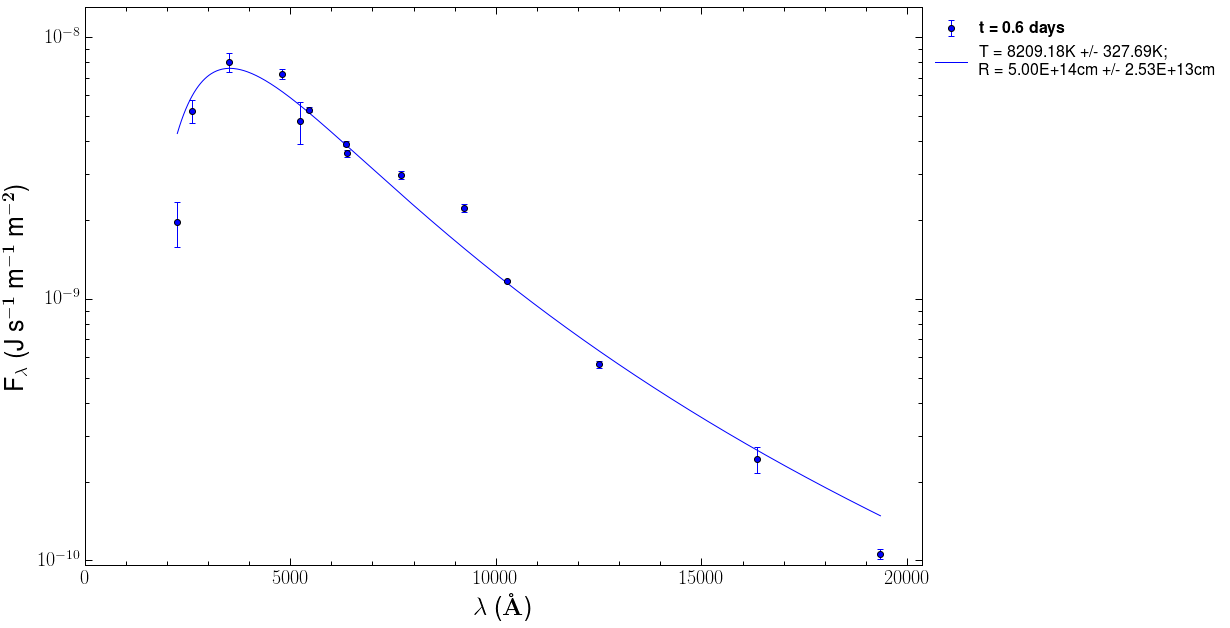

In [1530]:
SED()

In [1325]:
sig = Stefan_Boltzmann

def sed_table(gwsource = Villar):
    temp_list = []
    radius_list = []
    temp_sigma_list = []
    radius_sigma_list = []
    dof_list = []
    chi2_list = []
    L_bol_list = []
    L_bol_sig_list = []
    L_bol_list_BB = []
    L_bol_sig_list_BB = []
    
    
    print('Pick days after merger to plot (e.g. 1,5.7,20.368).')
    timez = input()
    timez = timez.split(',')
    times = []
    for time in timez:
        time_float = float(time)
        times.append(time_float)
        
    for time in times:
        data = sed_data(gwsource, time)
        
        #T and R with sigmas
        parameters, covariances = optimal_blackbody(time, data)
        temp_sig, radius_sig = np.sqrt(np.diag(covariances))
        temp = parameters[0]
        radius = parameters[1]
        temp_list.append(temp)
        radius_list.append(radius)
        temp_sigma_list.append(temp_sig)
        radius_sigma_list.append(radius_sig)
        
        
        #Chi^2 and degrees of freedom
        exp_data = blackbody_function(data['lambda'],parameters[0],parameters[1])
        dof = len(data)-len(parameters)
        dof_list.append(dof)
        chi2 = []
        for i in range(len(data)):
            chi = (data['flux'][i]-exp_data[i])**2/(data['e_flux'][i])**2
            if chi < 400:
                chi2.append(chi)
            else:
                chi2 = chi2
        chi2_tot = np.sum(chi2)
        chi2_list.append(chi2_tot)
        
        #Bolometric Luminosity
        conversion = 3.085677581e+24 #Mpc to cm
        d = 40.7*conversion
        to_erg = 1e7
        min_lambda = np.min(data['lambda'])
        max_lambda = np.max(data['lambda'])
        #lambdas = np.linspace(min_lambda, max_lambda, 1000)
        interp = Fbol_interp(data)
        Fbol = quad(interp, min_lambda, max_lambda)
        L_bol = Fbol[0]*4*np.pi*d**2
        L_bol_sig = Fbol[1]*4*np.pi*d**2
        L_bol_list.append(L_bol)
        L_bol_sig_list.append(L_bol_sig)
        
        #Bolometric Luminosity BB
        rad_new = radius/100
        rad_sig_new = radius_sig/100
        L_bol_BB = sig*temp**4*4*np.pi*rad_new**2
        L_bol_list_BB.append(L_bol_BB*to_erg)
        
        L_bol_sig_BB = np.sqrt((dL_dT(temp, rad_new)*temp_sig)**2+
                            (dL_dR(temp, rad_new)*rad_sig_new)**2+
                            dL_dT(temp, rad_new)*temp_sig*dL_dR(temp, rad_new)*rad_sig_new)
        L_bol_sig_list_BB.append(L_bol_sig_BB*to_erg)
        
    return Table([times, temp_list, temp_sigma_list, radius_list, radius_sigma_list, L_bol_list, L_bol_sig_list, 
                  L_bol_list_BB, L_bol_sig_list_BB, dof_list, chi2_list],
                 names=('time', 'temp', 'e_temp', 'radius', 'e_radius', 'L_bol', 'e_L_bol', 'L_bol_BB', 'e_L_bol_BB', 'dof', 'chi2'))



def dL_dT(temp, radius):
    return 4*sig*temp**3*4*np.pi*radius**2

def dL_dR(temp, radius):
    return 2*sig*temp**4*4*np.pi*radius


def Fbol_interp(sed_data):
    approx = 'linear'
    interp = interp1d(sed_data['lambda'], sed_data['flux']*1e-7, kind=approx)
    return interp

In [1326]:
def master_plot(gwsource=Villar):
    table = sed_table(gwsource)
    time = table['time']
    temp = table['temp']
    e_temp = table['e_temp']
    radius = table['radius']
    e_radius = table['e_radius']
    L_bol = table['L_bol']
    e_L_bol = table['e_L_bol']
    L_bol_BB = table['L_bol_BB']
    e_L_bol_BB = table['e_L_bol_BB']
    
    majorLocator = AutoLocator()
    minorLocator = AutoMinorLocator()
    
    fig = plt.figure(figsize=(15,10))
    
    #Bolometric Luminosity
    ax1 = plt.subplot(311)
    
    plt.errorbar(time, L_bol_BB, yerr=e_L_bol_BB,
                 fmt='o', markeredgecolor='k', markeredgewidth=1, label='L$_{\\mathbf{bol}}$ (BB)')
    plt.errorbar(time, L_bol, yerr=e_L_bol,
                 fmt='o', markeredgecolor='k', markeredgewidth=1, label='L$_{\\mathbf{bol}}$')
    
    
    #plt.xlabel('Days after Merger', fontsize=axeslabelsize)
    plt.ylabel('L$_$bol (erg s$^{\\mathbf{-1}}$)', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_major_locator(majorLocator)
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.xlim(0.5, max(time)+1)
    plt.legend(loc='lower left', bbox_to_anchor=(0.02,0.03), numpoints=1, fontsize=legend-3)
    
    #Tempurature
    ax2 = plt.subplot(312)
    
    plt.errorbar(time, temp, yerr=e_temp,
                 fmt='o', markeredgecolor='k', markeredgewidth=1)
    
    #plt.xlabel('Days after Merger', fontsize=axeslabelsize)
    plt.ylabel('Temperature (K)', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax2.xaxis.set_major_locator(majorLocator)
    ax2.xaxis.set_minor_locator(minorLocator)
    ax2.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax2.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.xlim(0.5, max(time)+1)
    
    
    #Radius
    ax3 = plt.subplot(313)
    
    plt.errorbar(time, radius, yerr=e_radius,
                 fmt='o', markeredgecolor='k', markeredgewidth=1)
    
    plt.xlabel('Days after Merger', fontsize=axeslabelsize)
    plt.ylabel('Radius (cm)', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax3.xaxis.set_major_locator(majorLocator)
    ax3.xaxis.set_minor_locator(minorLocator)
    ax3.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax3.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    plt.xlim(0.5, max(time)+1)
    return
    

In [1327]:
#master_plot()

In [1855]:
#sed_table(Villar)

# Summer Research

## Taking the code from Raf, we are now going to simulate light curves for LSST in the six following filters: u,g,r,i,z,y.

In [1710]:
bands = ['u','g','r','i','z','y']
LSST_bandpasses = bandpasses('LSST Filters')
LSST_transmissions = interp_bandpasses(LSST_bandpasses)
LSST_lambdas = lambda_effectives(LSST_bandpasses)

def LSST_light_curves(times, simulated=False, gwsource=Villar):
    min_time = 0.6
    max_time = 10
    min_obs = 4
    max_obs = 11
    u = []
    g = []
    r = []
    i = []
    z = []
    y = []
    
    u_blue = []
    g_blue = []
    r_blue = []
    i_blue = []
    z_blue = []
    y_blue = []
    u_purple = []
    g_purple = []
    r_purple = []
    i_purple = []
    z_purple = []
    y_purple = []
    u_red = []
    g_red = []
    r_red = []
    i_red = []
    z_red = []
    y_red = []
    for time in times:
        if simulated == True:
            blue,purple,red = BB_sed(time)
            
            blue_mags = LSST_mags(blue, time, gwsource, simulated)
            purple_mags = LSST_mags(purple, time, gwsource, simulated)
            red_mags = LSST_mags(red, time, gwsource, simulated)
            
            u_blue.append(blue_mags['u'])
            g_blue.append(blue_mags['g'])
            r_blue.append(blue_mags['r'])
            i_blue.append(blue_mags['i'])
            z_blue.append(blue_mags['z'])
            y_blue.append(blue_mags['y'])
            
            u_purple.append(purple_mags['u'])
            g_purple.append(purple_mags['g'])
            r_purple.append(purple_mags['r'])
            i_purple.append(purple_mags['i'])
            z_purple.append(purple_mags['z'])
            y_purple.append(purple_mags['y'])
            
            u_red.append(red_mags['u'])
            g_red.append(red_mags['g'])
            r_red.append(red_mags['r'])
            i_red.append(red_mags['i'])
            z_red.append(red_mags['z'])
            y_red.append(red_mags['y'])

        
        else:
            data = sed_data(gwsource, time)
            
            data.sort('lambda')
            mags = LSST_mags(data, time, gwsource)
            u.append(mags['u'])
            g.append(mags['g'])
            r.append(mags['r'])
            i.append(mags['i'])
            z.append(mags['z'])
            y.append(mags['y'])
            
        
    if simulated == True:
        lc_blue = Table([times,u_blue,g_blue,r_blue,i_blue,z_blue,y_blue], names=('day','u','g','r','i','z','y'))
        lc_purple = Table([times,u_purple,g_purple,r_purple,i_purple,z_purple,y_purple], names=('day','u','g','r','i','z','y'))
        lc_red = Table([times,u_red,g_red,r_red,i_red,z_red,y_red], names=('day','u','g','r','i','z','y'))
        return lc_blue, lc_purple, lc_red
    else:
        return Table([times,u,g,r,i,z,y], names=('day','u','g','r','i','z','y'))
    
    return
        
def LSST_mags(sed_data, time, gwsource, simulated=False):
    mags = {}
    sed_minlam = min(sed_data['lambda'])
    sed_maxlam = max(sed_data['lambda'])
    for band in bands:
        global sed_interp
        sed_interp = flux_interp(sed_data, band)
        #global sed_einterp
        #sed_einterp = flux_interp(sed_data, band)[1]
        lam_eff = LSST_lambdas['LSST '+band]
        LSST_lams = LSST_bandpasses['LSST '+band]
        global LSST_trans
        LSST_trans = LSST_transmissions['LSST '+band]
        LSST_minlam = min(LSST_lams['wavelength'])
        LSST_maxlam = max(LSST_lams['wavelength'])
        upperlimits = upperlimit(gwsource[np.where(gwsource['band']==band)], 'magnitude')
        times = reset_days(upperlimits['reg days'], trigger)
        if simulated == True:
            min_time = max(sed_minlam, LSST_minlam)
            max_time = min(sed_maxlam, LSST_maxlam)
            X = quad(flux_integral, min_time, max_time)[0]
            Y = quad(LSST_trans, min_time, max_time)[0]
            #X_sig = quad(eflux_integral, min_time, max_time)[0]
            #Y_sig = quad(LSST_trans, min_time, max_time)[0]
            flux = X/Y
            #e_flux = X_sig/Y_sig
            mag = convert_to_mag(flux, lam_eff)
            mags[band] = mag
        else:
            if time < max(times):
                min_time = max(sed_minlam, LSST_minlam)
                max_time = min(sed_maxlam, LSST_maxlam)
                X = quad(flux_integral, min_time, max_time)[0]
                Y = quad(LSST_trans, min_time, max_time)[0]
                #X_sig = quad(eflux_integral, min_time, max_time)[0]
                #Y_sig = quad(LSST_trans, min_time, max_time)[0]
                flux = X/Y
                #e_flux = X_sig/Y_sig
                mag = convert_to_mag(flux, lam_eff)
                mags[band] = mag
            else:
                mags[band] = np.inf
    return mags

def flux_interp(sed_data, band):
    if band in ['u','g','i','r','y']:
        approx = 'slinear'
    else:
        approx = 'cubic'
    #e_approx = 'linear'
    
    interp = interp1d(sed_data['lambda'], sed_data['flux']*1e-7, bounds_error=False, fill_value='extrapolate', kind=approx)
    #e_interp = interp1d(sed_data['lambda'], sed_data['e_flux']*1e-7, bounds_error=False, fill_value='extrapolate', kind=e_approx)
    return interp

def flux_integral(lam):
    return LSST_trans(lam)*sed_interp(lam)

def eflux_integral(lam):
    return LSST_trans(lam)*sed_einterp(lam)

def convert_to_mag(flux, lam_eff):
    c = astro.constants.c.to('Angstrom/s').value
    f_nu = (lam_eff**2/c)*flux
    #e_f_nu = (lam_eff**2/c)*e_flux
    mag = -2.5*np.log10(f_nu)-48.6
    #e_mag = 2.5/(np.log(10)*f_nu)*e_f_nu
    #abs_mag = mag-5*np.log10((40.7*1e6)/10)
    #abs_emag = e_mag
    return mag

In [1815]:
LSST_blue, LSST_purple, LSST_red = LSST_light_curves(np.linspace(0.01,15,30), simulated=True)

In [1381]:
#LSST

The GW source has the following filters:

['i', 'H', 'r', 'Ks', 'J', 'V', 'z', 'W', 'g', 'w', 'Y', 'M2', 'W1', 'U', 'W2', 'y', 'B', 'I', 'R', 'K', 'u', 'J1', 'F110W', 'F160W', 'F336W', 'J8.9', 'F606W', 'F475W', 'F625W', 'F775W', 'F850W', 'F814W', 'F225W', 'F275W']

Do you wish to plot in magnitude or flux?
Choose filters to plot (e.g. u,g,r,i,z):


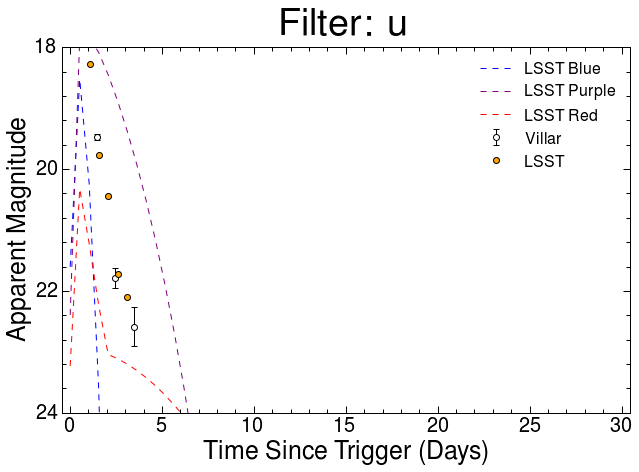

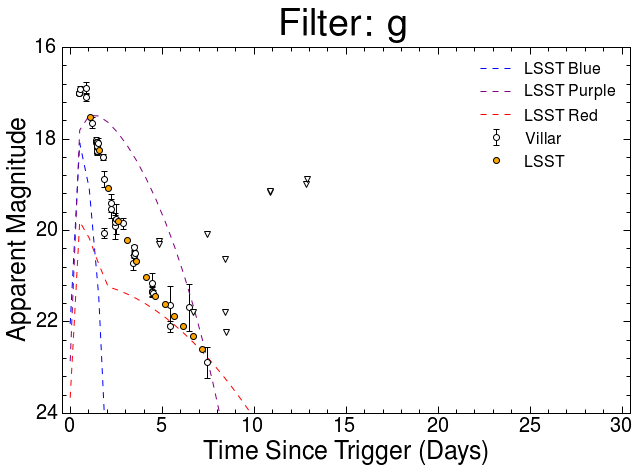

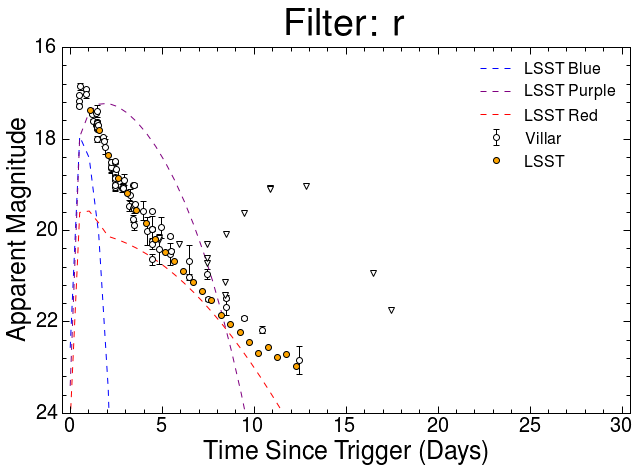

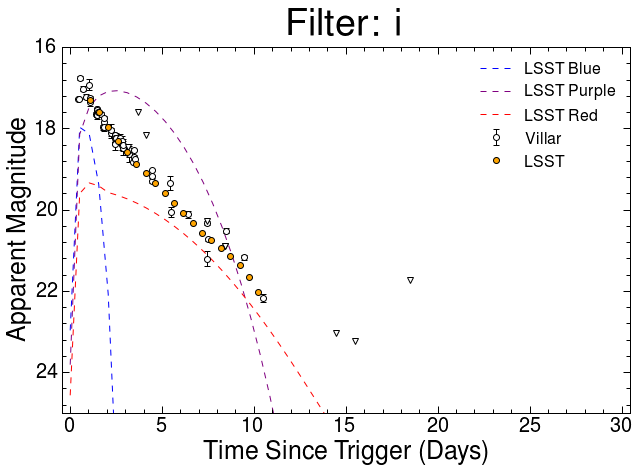

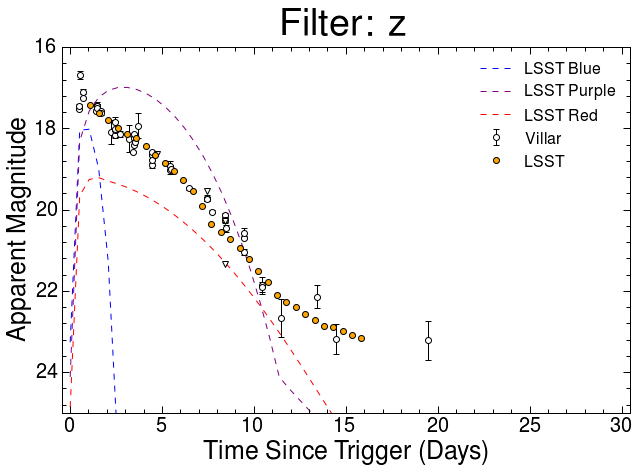

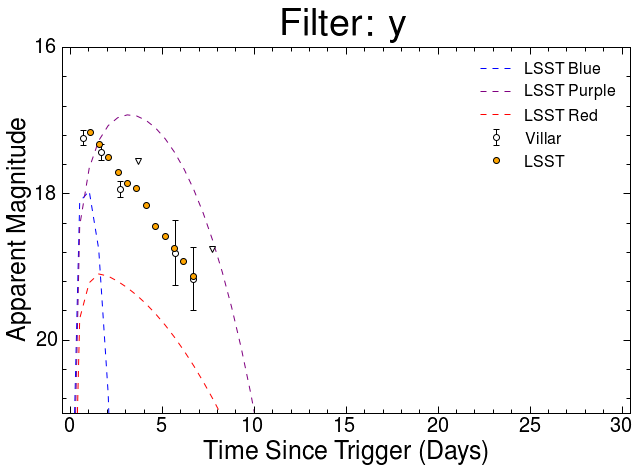

In [1816]:
plot_light_curve(Villar)

## Villar Light Curves

In [1697]:
Colors = ['blue', 'purple', 'red']

#Note: These dictionaries have lists that contain [mean, upperbound, lowerbound].
#Temperature (Temp) in Kelvin. Mass of ejecta (m_ej) in solar masses. Velocity of ejecta (v_ej) in fractions of c.
Temp = {'blue': [674.058, 416.996, 486.067], 'purple': [1307.972, 34.040, 42.067], 'red': [3745.062, 75.034, 75.337]}
m_ej = {'blue': [0.020, 0.001, 0.001], 'purple': [0.047, 0.001, 0.002], 'red': [0.011, 0.002, 0.001]}
v_ej = {'blue': [0.266, 0.008, 0.008], 'purple': [0.152, 0.005, 0.005], 'red': [0.137, 0.025, 0.021]}
Opacity = {'blue': 0.5, 'purple': 3, 'red':10}
beta = 13.4
t_0 = 1.3
sigma = 0.11
M_sol_g = astro.units.solMass.to('g')
e_th_table = ascii.read('e_th_table.csv')
sig_sb = Stefan_Boltzmann

In [1858]:
#
# Villar SED Creation
#

def BB_sed(time, colors=Colors):
    '''
    Inputs:
    -> time - float measured in days
    -> colors - list of strings denoting the different components of the kilonova model: blue, purple, and red
    
    Outputs:
    -> sed tables - three sed tables (one for each color) which are used in the function LSST_light_curves() to plot the
                    magnitudes of the three components
    '''
    trtable = BB_sim(time, colors)
    
    blue = np.where(table['color'] == 'blue')
    purple = np.where(table['color'] == 'purple')
    red = np.where(table['color'] == 'red')
    
    t_blue, r_blue = trtable[blue]['temp'], trtable[blue]['radius']
    t_purple, r_purple = trtable[purple]['temp'], trtable[purple]['radius']
    t_red, r_red = trtable[red]['temp'], trtable[red]['radius']
    
    BBblue = BB_interp(t_blue, r_blue)
    BBpurple = BB_interp(t_purple, r_purple)
    BBred = BB_interp(t_red, r_red)
    
    sed_blue = Table([BBblue[0], BBblue[1], np.zeros(len(BBblue[0]))], names=('lambda', 'flux', 'e_flux'))
    sed_purple = Table([BBpurple[0], BBpurple[1], np.zeros(len(BBpurple[0]))], names=('lambda', 'flux', 'e_flux'))
    sed_red = Table([BBred[0], BBred[1], np.zeros(len(BBred[0]))], names=('lambda', 'flux', 'e_flux'))
    
    return sed_blue, sed_purple, sed_red

def BB_interp(temp, radius):
    '''
    Inputs:
    -> temperature - float measured in kelvin
    -> radius - float measured in cm
    
    Outputs:
    -> blackbody curve - Array that contains a list of wavelengths and a list of fluxes measured by blackbody_function().
                         Note: blackbody_function() is in Research with Margutti under 'Black-Body Fits'
    '''
    steps = 1000
    min_lambda, max_lambda = LSST_range(LSST_bandpasses)
    lambdas = np.linspace(min_lambda, max_lambda, steps)
    curve = np.array([lambdas, blackbody_function(lambdas, temp, radius)])
    return curve

def LSST_range(bandpasses):
    '''
    Inputs:
    -> bandpasses - dictionary containing the transmission curves of the six LSST filters
    
    Outputs:
    -> min_lambda, max_lambda - floats measured in Angstroms; the two lambdas give the range of wavelngths for BB_interp
    '''
    lam_list = []
    for key,table in bandpasses.items():
        lam_list.append(min(table['wavelength']))
        lam_list.append(max(table['wavelength']))
    return min(lam_list), max(lam_list)

def BB_sim(time, colors):
    '''
    Inputs:
    -> time - float measured in days
    -> colors - list of strings denoting the different components of the kilonova model: blue, purple, and red
    
    Outputs:
    -> table - table containing the calculated temperature and radius for each of the color components at a particular time
    '''
    temp_list = []
    rad_list = []
    for color in colors:
        temp,rad = sed_sims(time, color)
        temp_list.append(temp)
        rad_list.append(rad)
    
    table = Table([colors, temp_list, rad_list], names=('color', 'temp', 'radius'))
    return table

def sed_sims(time, color):
    '''
    Inputs:
    -> time - float measured in days
    -> colors - list of strings denoting the different components of the kilonova model: blue, purple, and red
    
    Outputs:
    -> Temperature, Radius - two floats measure in K and cm respectively; calculated temperature and radius
                             from the equations in the Villar Paper
    '''
    t = time*86400
    M_ej = m_ej[color][0]
    V_ej = v_ej[color][0]
    T_c = Temp[color][0]
    opac = Opacity[color]
    temp = T_photo(t, M_ej, V_ej, opac, T_c)
    Temperature = max(temp, T_c)
    Radius = R_photo(t, M_ej, V_ej, opac, temp, T_c)
    return Temperature, Radius

def R_photo(t, m_ej, v_ej, opacity, temp, T_c):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> opacity - color's opacity; float measured in cm^2/g
    -> temp - calculated temperature at time t; float measured in K
    -> T_c - critical temperature for color component; float measured in K
    
    Outputs:
    -> radius - calculated radius at time t; float measured in cm
    '''
    radius = 0
    if temp > T_c:
        radius = (v_ej*c)*t
    elif temp <= T_c:
        radius = ((Lbol(t, m_ej, v_ej, opacity)*1e-7)/(4*np.pi*sig_sb*T_c**4))**0.5
    return radius*100

def T_photo(t, m_ej, v_ej, opacity, T_c):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> opacity - color's opacity; float measured in cm^2/g
    -> T_c - critical temperature for color component; float measured in K
    
    Outputs:
    -> temp - calculated temperature at time t; float measured in K
    '''
    temp = 0
    if t == 0:
        temp = T_c
    else:
        temp = ((Lbol(t, m_ej, v_ej, opacity)*1e-7)/(4*np.pi*sig_sb*((v_ej*c)*t)**2))**0.25
    return temp

def Lbol(t, m_ej, v_ej, opacity):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> opacity - color's opacity; float measured in cm^2/g
    
    Outputs:
    -> lbol - calculated bolometric luminosity at time t; float measured in erg/s
    '''
    T_d = t_d(m_ej, v_ej, opacity)
    lbol = 0
    if t == 0:
        lbol = 0
    else:
        lbol = np.exp(-(t/T_d)**2)*Lbol_integral(t, m_ej, v_ej, T_d)
    return lbol

def t_d(m_ej, v_ej, opacity):
    '''
    Inputs:
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> opacity - color's opacity; float measured in cm^2/g
    
    Outputs:
    -> t_d - calculated value of t_d (see Villar paper); float measured in seconds
    '''
    return np.sqrt((2*(opacity/10000)*(m_ej*M_sol_g))/(beta*(v_ej*c)*c))

def Lbol_integral(t, m_ej, v_ej, t_d):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> t_d - calculated value of t_d (see Villar paper); float measured in seconds
    
    Outputs:
    -> lbol_int - the integral part of Lbol() (see Villar paper); no useful output on its own, but measured in erg/s
    '''
    return quad(L_integrand, 0, t, args=(m_ej, v_ej, t_d))[0]

def L_integrand(t, m_ej, v_ej, t_d):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> t_d - calculated value of t_d (see Villar paper); float measured in seconds
    
    Outputs:
    -> l_integrand - the integrand of Lbol_integral() (see Villar paper); no useful output on its own, but measured in erg/s.
    '''
    return L_in(t, m_ej)*e_th(t, m_ej, v_ej)*np.exp((t/t_d)**2)*(t/t_d)

def L_in(t, m_ej):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    
    Outputs:
    -> l_in - function used in Lbol() (see Villar paper); units of erg/s
    '''
    return 4e18*(m_ej*M_sol_g)*(0.5-(1/np.pi)*np.arctan((t-t_0)/sigma))**1.3

def e_th(t, m_ej, v_ej):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    
    Outputs:
    -> e_th - function used in Lbol() (see Villar paper); it is a float X such that 0 < X < 1.
    '''
    num = 0
    a,b,d = calc_coeffs(m_ej, v_ej)
    return 0.36*(np.exp(-a[num]*t)+(np.log(1+2*b[num]*t**d[num])/(2*b[num]*t**d[num])))

def calc_coeffs(m_ej, v_ej):
    '''
    Inputs:
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    
    Outputs:
    -> coeffs_list - array containing lists of the coefficiencts a, b, and d. 
                     Note: Each coefficient has three different values [i_rand, i_rad, i_tor] for i in {a,b,d}; rand, rad, and tor are
                            different measurements for a, b, and d depending on the data points used (see Barnes et al. 2016).
    '''
    a_list = []
    b_list = []
    d_list = []
    a_interps = e_th_interps('a')
    b_interps = e_th_interps('b')
    d_interps = e_th_interps('d')
    
    for a,b,d in zip(a_interps, b_interps, d_interps):
        a_list.append(abs(a(m_ej, v_ej)))
        b_list.append(abs(b(m_ej, v_ej)))
        d_list.append(abs(d(m_ej, v_ej)))
        
    return [a_list, b_list, d_list]

def e_th_interps(coeff):
    '''
    Input:
    -> coeff - string representing the coefficient a, b, and d
    
    Output:
    e_th_interps - a list of 2D interpolations for the coefficient; interpolations are dependent on ejecta mass and velocity
                   Note: there are three interpolations for one component: random (rand), radial (rad), and toroidal (tor);
                           see Barnes et al. 2016 for more explanation.
    '''
    function = 'linear'
    m_ej = e_th_table['m_ej']
    v_ej = e_th_table['v_ej']
    coordinates = np.column_stack([m_ej, v_ej])
    coeff_rand = e_th_table[coeff+'_rand']
    coeff_rad = e_th_table[coeff+'_rad']
    coeff_tor = e_th_table[coeff+'_tor']
    
    num=0
    rand_interp = Rbf(m_ej, v_ej, coeff_rand, function = function, smooth=num)
    rad_interp = Rbf(m_ej, v_ej, coeff_rad, function = function, smooth=num)
    tor_interp = Rbf(m_ej, v_ej, coeff_tor, function = function, smooth=num)
    return [rand_interp, rad_interp, tor_interp]
    
    

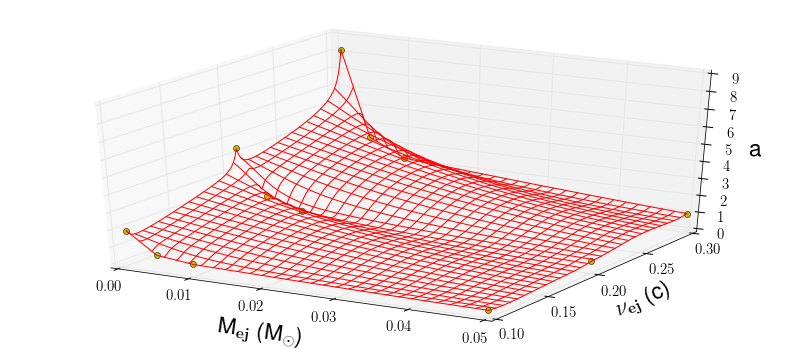

In [1701]:
from mpl_toolkits import mplot3d
const = 'a'
number = 0
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(e_th_table['m_ej'], e_th_table['v_ej'], e_th_table[const+'_rand'], 'yo', markeredgecolor='k')
majorLocator = AutoLocator()
minorLocator = AutoMinorLocator()
ax.set_xlabel('M$_{\\mathbf{ej}}$ (M$_{\\mathbf{\odot}}$)', fontsize=axeslabelsize/1.1) 
ax.set_ylabel('$\\nu_{\\mathbf{ej}}$ (c)', fontsize=axeslabelsize/1.1)
ax.set_zlabel(const, fontsize=axeslabelsize/1.1) 
ax.yaxis.labelpad=15
ax.xaxis.labelpad=25
ax.tick_params(axis='x', labelsize=tickfontsize/2+5)
ax.tick_params(axis='y', labelsize=tickfontsize/2+5)
ax.tick_params(axis='z', labelsize=tickfontsize/2+5)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
ax.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')

for M_ej in np.linspace(0.001, 0.05, 30):
    xnew = np.linspace(M_ej, M_ej, 1000)
    ynew = np.linspace(0.1, 0.3, 1000)
    znew = e_th_interps(const)[number](xnew, ynew)
    ax.plot(xnew, ynew, znew, 'r-')
    
for V_ej in np.linspace(0.1, 0.3, 30):
    xnew = np.linspace(0.001, 0.05, 1000)
    ynew = np.linspace(V_ej, V_ej, 1000)
    znew = e_th_interps(const)[number](xnew, ynew)
    ax.plot(xnew, ynew, znew, 'r-')  
    
plt.show()

In [1810]:
blue, purple, red = BB_sed(0.6)

In [1859]:
#BB_sim(0.6, Colors)

In [1860]:
#purple

In [1861]:
#sed_data(Villar, 0.6)

In [1862]:
#L_in(0.6, m_ej['purple'][0])

In [1863]:
#Lbol(0.6, m_ej['blue'][0], v_ej['blue'][0], opacity['blue'])

In [1864]:
#e_th_table